In [66]:
import numpy as np 
import cosmology as cosmo
import healpy as hp
import matplotlib.pyplot as plt
import scipy.constants as cons
from joblib import Parallel, delayed

In [67]:
cosmo_wsp = cosmo.cosmology()

In [68]:
gridsz = 128 
gridsz_in_Mpc = 7700 / 6144  # in Mpc; 7700 Mpc box length for websky 6144 cube

In [69]:
file = '../../../../../websky_datacube/small_cube_128.npz'#'/global/cfs/cdirs/mp107/exgal/data/xgsm/small_cube_128.npz' 
with np.load(file) as cube:
    delta0 = cube['delta']
    sx = cube['sx']
    sy = cube['sy']
    sz = cube['sz']

cube.close()

In [70]:
cube_axis = np.arange(gridsz)

grid_qx, grid_qy, grid_qz = np.meshgrid(cube_axis, cube_axis, cube_axis, indexing='ij')

In [71]:
comov_q = np.sqrt((grid_qx+ 0.5)**2. + (grid_qy+0.5)**2. + (grid_qz+0.5)**2.) * gridsz_in_Mpc

grid_redshift = cosmo_wsp.comoving_distance2z(comov_q)
growthD = cosmo_wsp.growth_factor_D(grid_redshift)

In [ ]:
print(np.min(comov_q[0,0]), np.max(comov_q[0,0]),np.min(comov_q[:,0,0]), np.max(comov_q[:,0,0]), np.min(comov_q[0,:,0]), np.max(comov_q[0,:,0]))

In [ ]:
plt.imshow(comov_q[0,:,:], cmap=plt.cm.Blues, origin='lower')
plt.title('Initial comoving distance (Lagrangian)')
plt.colorbar()

In [ ]:
plt.imshow(grid_redshift[0,:,:], cmap=plt.cm.Blues, origin='lower')
plt.title('Redshift for the box')
plt.colorbar()

In [ ]:
plt.imshow(growthD[0,:,:], cmap=plt.cm.Blues, origin='lower')
plt.title(r'Growth factor $D$ ')
plt.colorbar()

In [72]:
delta_z = growthD * delta0

grid_Xx = grid_qx + (growthD * sx)
grid_Xy = grid_qy + (growthD * sy)
grid_Xz = grid_qz + (growthD * sz)

In [ ]:
plt.imshow(delta_z[0,:,:], cmap=plt.cm.coolwarm, origin='lower')
plt.title(r'$\delta(\vec q) \times D(z)$ x=0 slice')
plt.colorbar()

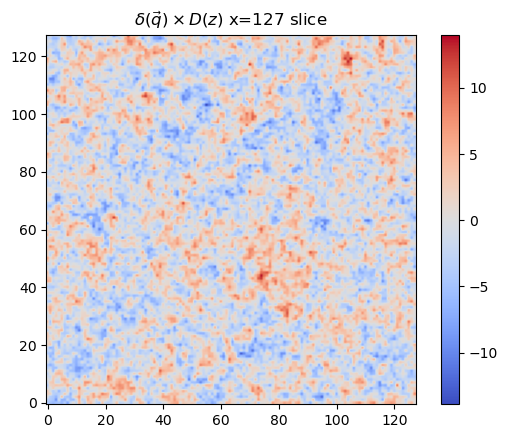

In [ ]:
plt.imshow(delta_z[-1,:,:], cmap=plt.cm.coolwarm, origin='lower')
plt.title(r'$\delta(\vec q) \times D(z)$ x=127 slice')
plt.colorbar()

In [73]:
comov_X = np.sqrt((grid_Xx+ 0.5)**2. + (grid_Xy+0.5)**2. + (grid_Xz+0.5)**2.) * gridsz_in_Mpc

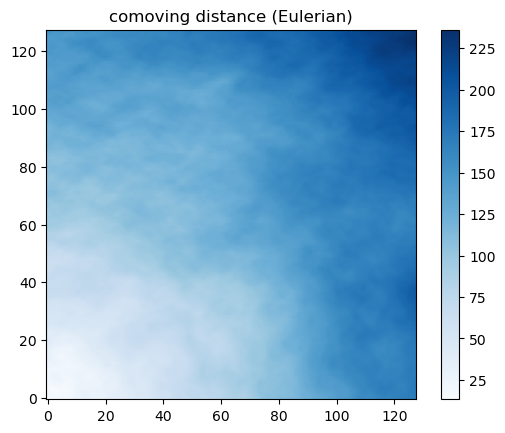

In [ ]:
plt.imshow(comov_X[0,:,:], cmap=plt.cm.Blues, origin='lower')
plt.title('comoving distance (Eulerian)')
plt.colorbar()

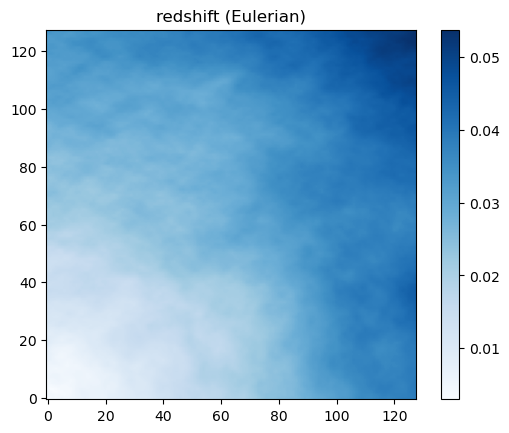

In [ ]:
eulerian_redshift = cosmo_wsp.comoving_distance2z(comov_X)
plt.imshow(eulerian_redshift[0,:,:], cmap=plt.cm.Blues, origin='lower')
plt.title('redshift (Eulerian)')
plt.colorbar()

In [74]:
nside = 128
norm = np.sqrt(grid_Xx**2. + grid_Xy**2. + grid_Xz**2.)
pix = hp.vec2pix(nside, (grid_Xx/norm).flatten(), (grid_Xy/norm).flatten(), (grid_Xz/norm).flatten())
pix_grid = pix.reshape((gridsz, gridsz, gridsz))

del pix

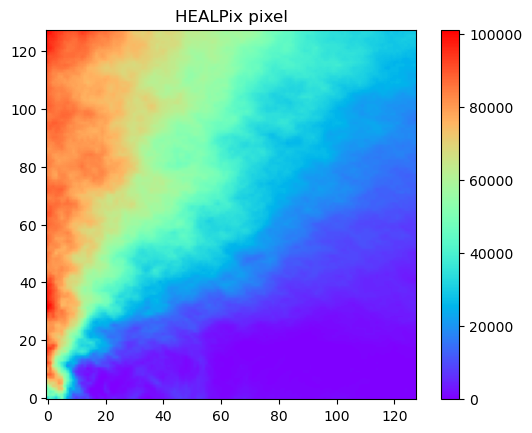

In [75]:
plt.imshow(pix_grid[0,:,:], cmap=plt.cm.rainbow, origin='lower')
plt.title('HEALPix pixel')
plt.colorbar()

In [76]:
pix_valid, npix_valid = np.unique(pix_grid, return_counts=True)

### Lensing kernel for the field term:

#### $W_\kappa(\chi_q) = \frac{3}{2} \frac{\Omega_{M,0}\ H^2_0(1+z)}{c^2} \frac{\left(1 - \chi_q\ /\chi_{q,*}\ \right)}{\chi_q}$

### Field term for each lattice point:

#### $\delta F_{ij} = \left(\frac{L_{\rm box}}{6144}\right)^3\frac{1}{\Omega_{\rm pix}} W_\kappa(z_i, \vec q_i)$

Questions: 
Is it $c^2$ or $c$ factor in the denominator? (it is $c^2$) 
For the $W_\kappa(z_i, \vec q_i)$ term do we need to multiply a $d\chi/dz$ factor? (no, it is already included)

In [77]:
X_s = 13.8 * 1.e3 # comoving distance to last scattering in Mpc
geometric_factor = gridsz_in_Mpc**3. / hp.nside2pixarea(nside)
lensing_kernel_grid = geometric_factor * (3./2.) * cosmo_wsp.params['Omega_m'] * (cosmo_wsp.params['h'] * 100. * cons.kilo / cons.c)**2. * (1 + grid_redshift) * (1. - (comov_q/X_s)) / comov_q 

In [ ]:
cons.c /cons.kilo

299792.458

In [ ]:
cosmo_wsp.params['h']

0.6732

In [ ]:
cons.physical_constants['speed of light in vacuum']

(299792458.0, 'm s^-1', 0.0)

(0.0, 5.0)

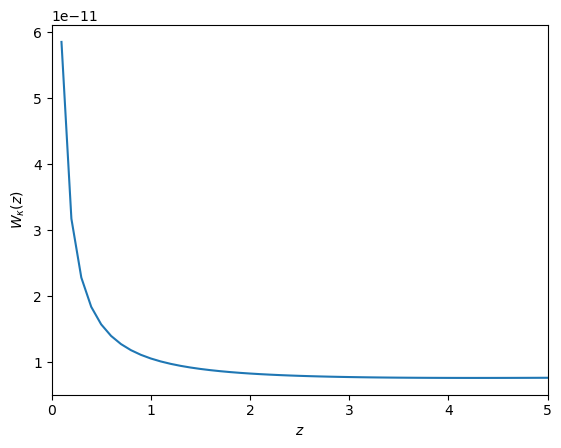

In [78]:
z = np.linspace(0.1, 10,100)
chi = cosmo_wsp.comoving_distance(z)
H_z = cosmo_wsp.Hubble_H(z)
W_kappa = (3./2.) * cosmo_wsp.params['Omega_m'] * (cosmo_wsp.params['h'] * 100. * cons.kilo / cons.c)**2. * (1 + z)  * (1. - (chi/X_s)) / chi

plt.plot(z,W_kappa)
plt.xlabel(r'$z$')
plt.ylabel(r'$W_\kappa(z)$')
plt.gca().set_xlim((0,5))

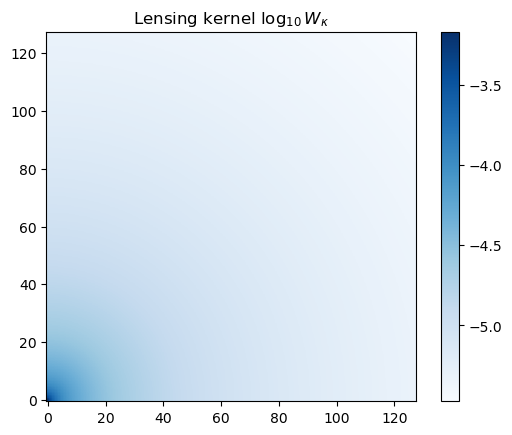

In [80]:
plt.imshow(np.log10(lensing_kernel_grid[0,:,:]), cmap=plt.cm.Blues, origin='lower')
plt.title(r'Lensing kernel $\log_{10} W_\kappa$')
plt.colorbar()

In [81]:
mask_comov = comov_q <= np.max(comov_q[0,0,:])
print(np.sum(mask_comov))

1085261


In [82]:
def LoS_integration4hpx(field, kernel, los_variable, comov_mask):
    return np.sum(kernel)#, x=los_variable[comov_mask])

def call_LoSinteg(ipix):
    sel = np.where(pix_grid.flatten() == ipix)[0]
    return LoS_integration4hpx(delta_z.flatten()[sel], lensing_kernel_grid.flatten()[sel], comov_q.flatten()[sel], mask_comov.flatten()[sel])
    

In [83]:
# method 1
npix = 12*nside**2
kappa_hist, edges = np.histogram(pix_grid,bins=npix,range=(-0.5,npix-0.5),weights=lensing_kernel_grid,density=False)

In [84]:
# method 2
kappa_values = Parallel(n_jobs=-2, prefer="threads")(delayed (call_LoSinteg)(pix) for pix in pix_valid)
kappa = np.zeros(hp.nside2npix(nside))
kappa[pix_valid] = kappa_values

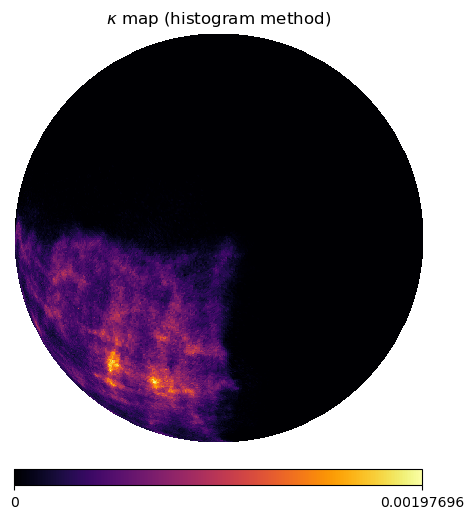

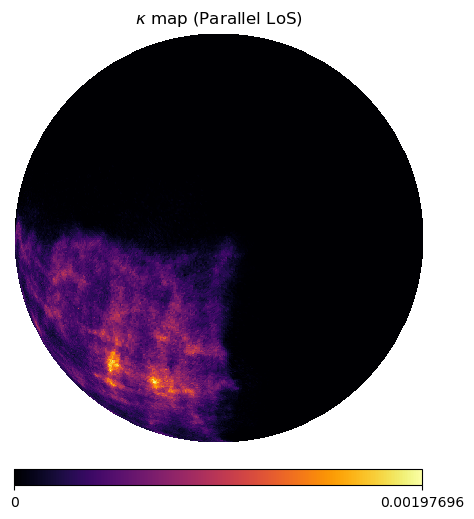

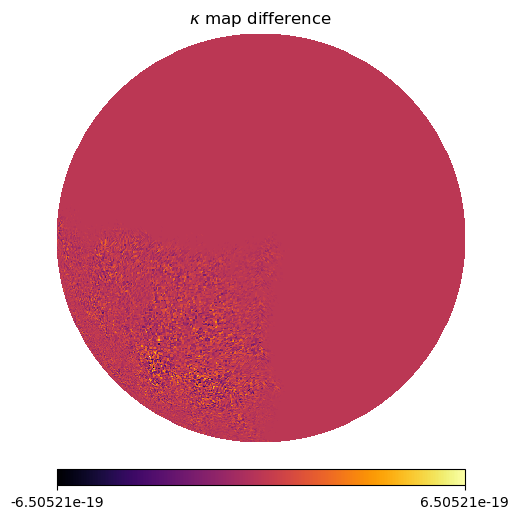

In [87]:
hp.orthview(kappa_hist,rot=[0.,90.,0.], cmap='inferno', half_sky=True, title=r'$\kappa$ map (histogram method)')
hp.orthview(kappa,rot=[0.,90.,0.], cmap='inferno', half_sky=True, title=r'$\kappa$ map (Parallel LoS)')
hp.orthview(kappa-kappa_hist,rot=[0.,90.,0.], cmap='inferno', half_sky=True, title=r'$\kappa$ map difference')


In [144]:
len(pix_valid)

33784

In [145]:
len(kappa[kappa>0])

33519

In [146]:
len(kappa_hist[kappa_hist>0])

33784